In [7]:
import os
import json
import random
import re
from shutil import copyfile
import numpy as np
from PIL import Image
import cv2

def create_coco_annotation(image_id, category_id, bbox, segmentation, annotations):
    annotation = {
        "id": len(annotations) + 1,
        "image_id": image_id,
        "category_id": category_id,
        "bbox": bbox,
        "area": bbox[2] * bbox[3],
        "segmentation": segmentation,
        "iscrowd": 0,
    }
    annotations.append(annotation)
    return annotation

def extract_segmentation(mask_path, bboxidx):
    mask_img = Image.open(mask_path).convert('L')
    mask_np = np.array(mask_img)
    mask_bbox = np.zeros_like(mask_np)
    mask_bbox[mask_np == bboxidx] = 255
    contours, _ = cv2.findContours(mask_bbox, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    segmentation = contour.flatten().tolist()
    return [segmentation]

def convert_pennfudan_to_coco(dataset_dir, coco_dir, train_val_split=0.9):
    os.makedirs(os.path.join(coco_dir, 'annotations'), exist_ok=True)
    os.makedirs(os.path.join(coco_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(coco_dir, 'val'), exist_ok=True)
    image_files = [filename for filename in os.listdir(os.path.join(dataset_dir, 'PNGImages')) if filename.endswith('.png')]
    random.seed(42)
    random.shuffle(image_files)
    train_split = int(train_val_split * len(image_files))
    train_images = image_files[:train_split]
    val_images = image_files[train_split:]
    coco_data_train = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "person"}],
    }
    train_annotations = coco_data_train['annotations']

    for image_id, image_filename in enumerate(train_images, start=1):
        # update the image size
        img = Image.open(os.path.join(dataset_dir, 'PNGImages', image_filename))
        width, height = img.size

        image_info = {
            "id": image_id,
            "file_name": image_filename,
            "height": height,
            "width": width,
        }
        coco_data_train['images'].append(image_info)
        annotation_filename = image_filename.replace('.png', '.txt')
        annotation_filepath = os.path.join(dataset_dir, 'Annotation', annotation_filename)
        try:
            with open(annotation_filepath, 'r') as annotation_file:
                lines = annotation_file.readlines()
        except FileNotFoundError:
            print(f"Annotation file {annotation_filename} not found. Skipping this image.")
            continue

        bboxidx=0
        for i, line in enumerate(lines):
            if line.startswith('Bounding box'):
                match = re.search(r'\((\d+),\s(\d+)\)\s-\s\((\d+),\s(\d+)\)', line)
                xmin, ymin, xmax, ymax = map(int, match.groups())
                bbox = [
                    xmin,
                    ymin,
                    xmax - xmin,
                    ymax - ymin,
                ]
                bboxidx+=1
                mask_filename = lines[i + 1].strip().split('/')[-1][0:-1]
                mask_filepath = os.path.join(dataset_dir, 'PedMasks', mask_filename)
                try:
                    segmentation = extract_segmentation(mask_filepath, bboxidx)
                except ValueError:
                    print(f"Couldn't extract segmentation for bbox {bboxidx} in image {image_filename}. Skipping this bounding box.")
                    continue
                annotation = create_coco_annotation(
                    image_id=image_id,
                    category_id=1,
                    bbox=bbox,
                    segmentation=segmentation,
                    annotations=train_annotations
                )
                train_annotations.append(annotation)
        src_image_path = os.path.join(dataset_dir, 'PNGImages', image_filename)
        dst_image_path = os.path.join(coco_dir, 'train', image_filename)
        copyfile(src_image_path, dst_image_path)
    with open(os.path.join(coco_dir, 'annotations', 'instances_train.json'), 'w') as f:
        json.dump(coco_data_train, f)

    coco_data_val = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "person"}],
    }
    val_annotations = coco_data_val['annotations']

    for image_id, image_filename in enumerate(val_images, start=1):
        # update the image size
        img = Image.open(os.path.join(dataset_dir, 'PNGImages', image_filename))
        width, height = img.size

        image_info = {
            "id": image_id,
            "file_name": image_filename,
            "height": height,
            "width": width,
        }
        coco_data_val['images'].append(image_info)
        annotation_filename = image_filename.replace('.png', '.txt')
        annotation_filepath = os.path.join(dataset_dir, 'Annotation', annotation_filename)
        try:
            with open(annotation_filepath, 'r') as annotation_file:
                lines = annotation_file.readlines()
        except FileNotFoundError:
            print(f"Annotation file {annotation_filename} not found. Skipping this image.")
            continue

        bboxidx=0
        for i, line in enumerate(lines):
            if line.startswith('Bounding box'):
                match = re.search(r'\((\d+),\s(\d+)\)\s-\s\((\d+),\s(\d+)\)', line)
                xmin, ymin, xmax, ymax = map(int, match.groups())
                bbox = [
                    xmin,
                    ymin,
                    xmax - xmin,
                    ymax - ymin,
                ]
                bboxidx+=1
                mask_filename = lines[i + 1].strip().split('/')[-1][0:-1]
                mask_filepath = os.path.join(dataset_dir, 'PedMasks', mask_filename)
                try:
                    segmentation = extract_segmentation(mask_filepath, bboxidx)
                except ValueError:
                    print(f"Couldn't extract segmentation for bbox {bboxidx} in image {image_filename}. Skipping this bounding box.")
                    continue
                annotation = create_coco_annotation(
                    image_id=image_id,
                    category_id=1,
                    bbox=bbox,
                    segmentation=segmentation,
                    annotations=val_annotations
                )
                val_annotations.append(annotation)
        src_image_path = os.path.join(dataset_dir, 'PNGImages', image_filename)
        dst_image_path = os.path.join(coco_dir, 'val', image_filename)
        copyfile(src_image_path, dst_image_path)
    with open(os.path.join(coco_dir, 'annotations', 'instances_val.json'), 'w') as f:
        json.dump(coco_data_val, f)


In [8]:
! rm -rf /home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFundaCoco

In [9]:
# Set the paths for the Penn-Fudan dataset and the destination COCO dataset
dataset_dir = '/home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFudanPed'
coco_dir = '/home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFundaCoco'

# Convert Penn-Fudan to COCO format
convert_pennfudan_to_coco(dataset_dir, coco_dir)

In [10]:
! pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os
import random

def get_random_color():
    """Return a random RGB color."""
    return np.random.randint(0, 255, 3)

def visualize_coco_annotations(coco_dir, coco_annotation_file):
    # Initialize COCO API for instance annotations
    coco = COCO(os.path.join(coco_dir, 'annotations', coco_annotation_file))
    
    print(f"Path is {os.path.join(coco_dir, 'annotations', coco_annotation_file)}")

    # Get all image ids
    image_ids = coco.getImgIds()
    
    print(f"Total image ids are {len(image_ids)}")

    # Select a random image id
    selected_image_id = random.choice(image_ids)

    # Load the image
    image = coco.loadImgs(selected_image_id)[0]
    image_filename = image['file_name']

    # Load and plot the image
    img = cv2.imread(os.path.join(coco_dir, 'train',image_filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_alpha = img.copy()

    # Get all annotations of the selected image
    annotation_ids = coco.getAnnIds(imgIds=selected_image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Loop through the annotations
    for ann in annotations:
        # Draw the bounding box
        [x, y, width, height] = ann['bbox']
        cv2.rectangle(img_alpha, (x, y), (x + width, y + height), (255, 0, 0), 2)

        # Draw the segmentation mask
        mask = coco.annToMask(ann)
        color = get_random_color()
        img_alpha[mask > 0] = img_alpha[mask > 0] * 0.5 + color * 0.5

        # Draw the category name
        cat_id = ann['category_id']
        cat = coco.loadCats(cat_id)[0]['name']
        cv2.putText(img_alpha, cat, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    plt.imshow(img_alpha)
    plt.show()


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Path is /home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFundaCoco/annotations/instances_train.json
Total image ids are 153


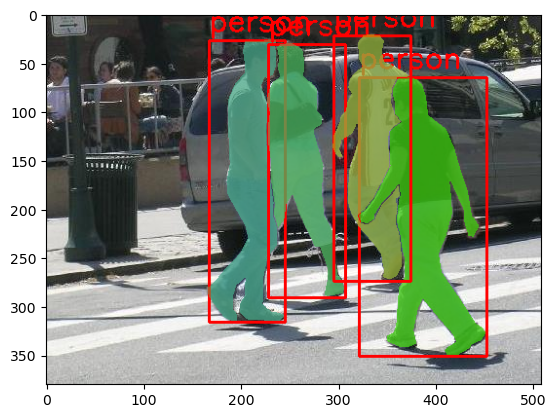

In [44]:
# Set the paths for the COCO dataset
coco_dir =  '/home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFundaCoco'

# Call the function
visualize_coco_annotations(coco_dir=coco_dir, coco_annotation_file='instances_train.json')


In [ ]:
img=cv2.imread("/home/ec2-user/SageMaker/Nano-Instance-Segmentor/data/PennFudanPed/PedMasks/FudanPed00001_mask.png")

In [ ]:
img.min(),img.max()

In [ ]:
#plt.imshow(img*255)